In [5]:
import os

# Change this to your image folder path
image_folder = './extracted'

# Check if the folder exists
os.path.exists(image_folder)

True

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import ResNet18_Weights 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import copy
from PIL import Image 

In [ ]:
pip install pandas

In [ ]:
pip install torch torchvision torchaudio

In [2]:
import torch
print(torch.cuda.is_available()) 

True


In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class WikiArtsDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None): 
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform 
        self.target_transform = target_transform
        
    def __len__(self): 
        return len(self.img_labels)
    
    def __getitem__(self, idx): 
        img_path = self.img_labels.iloc[idx, 0]
        #image = read_image(img_path)
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [24]:
all_labels_df = pd.read_csv("WikiArts_labeled.csv")
genres = sorted(list(all_labels_df.iloc[:, 1].unique()))
num_classes = len(genres)

class_to_idx = {genre_name: i for i, genre_name in enumerate(genres)}
idx_to_class = {i: genre_name for i, genre_name in enumerate(genres)}

label_transform = lambda x: class_to_idx[x]

In [29]:
num_classes

27

In [25]:
dataset = WikiArtsDataset("WikiArts_labeled.csv", img_dir=None, transform=transform, target_transform=label_transform)

In [26]:
generator = torch.Generator().manual_seed(40)
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size
train, test = random_split(dataset, [train_size, test_size], generator=generator)

In [27]:
train_dataloader = DataLoader(train, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test, batch_size=128, shuffle=True)

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [51]:
weights = ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)


In [52]:
for param in model.parameters(): 
    param.requires_grad = False

in_features = model.fc.in_features

# The WikiArts dataset has 27 features, whose parameters will be trainable. 
model.fc = nn.Linear(in_features, 27)

In [53]:
model = model.to(device)

In [54]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [55]:
def train_resnet18(model, optimizer, criterion, train_loader, epochs): 
    running_loss = []
    running_avg = 0
    i = 0
    for epoch in range(epochs): 
        epoch_loss = 0
        for inputs, labels in train_loader: 
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            running_avg += loss.item()
            
            if (i+1) % 100 == 0: 
                print(running_avg/100)
                running_loss.append(running_avg / 100)
                running_avg = 0

            i += 1

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}/{len(train_loader)}')

    return model.state_dict(), running_loss

In [56]:
criterion = nn.CrossEntropyLoss()        

In [68]:
trained_weights, running_loss2 = train_resnet18(model, optimizer, criterion, train_dataloader, 2)

1.5597229874134064
1.5637556552886962
1.5636085438728333
1.5806154370307923
1.5507441747188568
Epoch 1/2, Loss: 783.5601925849915/501
1.556209808588028
1.5646318018436431
1.568508619070053
1.5551085376739502
1.5623114025592804
Epoch 2/2, Loss: 782.0856893062592/501


Text(0, 0.5, 'Training Loss')

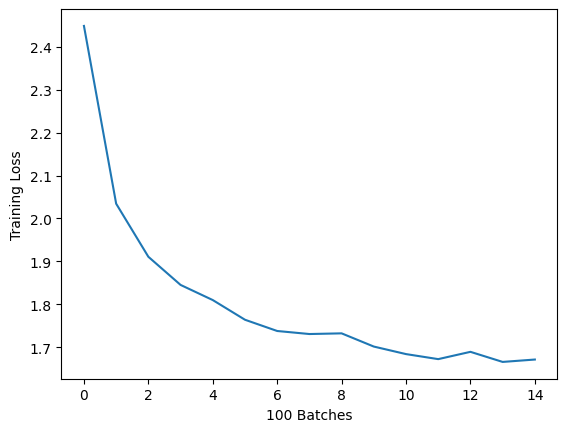

In [61]:
plt.plot(running_loss)  
plt.xlabel("100 Batches")          
plt.ylabel("Training Loss")    

Text(0, 0.5, 'Training Loss')

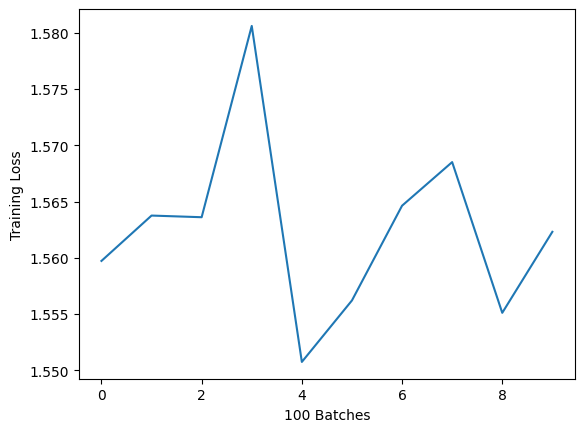

In [70]:
plt.plot(running_loss2)  
plt.xlabel("100 Batches")          
plt.ylabel("Training Loss")

In [64]:
torch.save(trained_weights, "resnet18savedweights.pt")

In [62]:
running_loss_1 = running_loss

In [67]:
print(f"Old learning rate: {optimizer.param_groups[0]['lr']}")



Old learning rate: 0.0001


In [66]:
# 2. Set the new learning rate
new_lr = 0.0001
for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr

In [1]:
pip install grad-cam

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 10.2 MB/s eta 0:00:000:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.1 MB/s eta 0:00:000m eta 0:00:010:00:01
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=8b99132bdfe84b12c2edbf051a5d9e9db9ccc8cee6fc5d94998e3997d8756c86
  Stored in directory: /common/home/rzs9/.cache/pip/wheels/3d/b6/be/e13cccebb2aa8855f678b02ad449e803de1dfbe75853c34b3e
Successfully built grad-cam

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
